In [47]:
import pypsa
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### 1. Get technologies from the Powerplant, Storage and Exchange Units CSV files

In [34]:
# read the csv file powerplant_units.csv
powerplants=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\powerplant_units.csv')
powerplants=powerplants[['name','technology']]
# rename technologies 'open cycle gas turbine', 'gas steam turbine' , 'combined cycle gas turbine' to 'natural gas'
powerplants['technology'] = powerplants['technology'].replace({
    'open cycle gas turbine': 'natural gas',
    'gas steam turbine': 'natural gas',
    'combined cycle gas turbine': 'natural gas',
    'gas engine': 'natural gas',
    'small gas mix': 'natural gas'
})
# rename the column name to unit_id to merge with redispatch_orders
powerplants = powerplants.rename(columns={'name': 'unit_id'})
powerplants.head(2)

,unit_id,technology
0,Unit_0,natural gas
1,Unit_1,natural gas


In [35]:
storage_units=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\storage_units.csv')
storage_units=storage_units[['name','technology']]
storage_units = storage_units.rename(columns={'name': 'unit_id'})
storage_units.head(2)

,unit_id,technology
0,battery_li_ion0,li_ion_battery
1,battery_li_ion1,li_ion_battery


In [36]:
# similarly add exchange_units
exchange_units=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\exchange_units.csv')
# add column technology with value 'exchange'
exchange_units['technology'] = 'exchange_units'
exchange_units=exchange_units[['name','technology']]
exchange_units = exchange_units.rename(columns={'name': 'unit_id'})
exchange_units.head(2)

,unit_id,technology
0,DE_AT_merged_way/26971631-220+1,exchange_units
1,DE_AT_merged_way/30970013-1-380+3,exchange_units


In [37]:
# merge powerplants and storage_units dataframes
units = pd.concat([powerplants, storage_units,exchange_units], ignore_index=True)
print("Unique technologies in powerplants:", units['technology'].unique())
units.head(2)

Unique technologies in powerplants: ['natural gas' 'hard coal' 'lignite' 'oil' 'waste' 'wind offshore'
 'solar pv' 'wind onshore' 'biomass' 'hydro' 'li_ion_battery' 'PSPP'
 'compressed_air_storage' 'exchange_units']


,unit_id,technology
0,Unit_0,natural gas
1,Unit_1,natural gas


In [38]:
units = units.set_index("unit_id")

### 2. Import pypsa.nc file to analyse it

In [39]:
fn = r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\outputs\pypsa_nc\redispatch_full_redispatch.nc"  # adjust to your path

n = pypsa.Network()
n.import_from_netcdf(fn)

# Quick sanity checks
print("Snapshots:", len(n.snapshots))
print("Generators:", len(n.generators))
print("Lines:", len(n.lines))

Index(['demand_CRM_pos', 'demand_CRM_neg'], dtype='object', name='name')
INFO:pypsa.io:Imported network redispatch_full_redispatch.nc has buses, carriers, generators, lines, loads


Snapshots: 24
Generators: 5646
Lines: 1076


In [40]:
gen_p = n.generators_t.p.copy()

up_cols = [c for c in gen_p.columns if c.endswith("_up")]
dn_cols = [c for c in gen_p.columns if c.endswith("_down")]

up = gen_p[up_cols] if up_cols else pd.DataFrame(index=n.snapshots)
dn = gen_p[dn_cols] if dn_cols else pd.DataFrame(index=n.snapshots)

# Aggregate MW by time
up_total = up.sum(axis=1)
dn_total = dn.sum(axis=1)

pd.DataFrame({"up_total_MW": up_total, "down_total_MW": dn_total}).head()

,up_total_MW,down_total_MW
snapshot,,
0,12247.094483,12247.094483
1,9875.961262,9875.961262
2,10503.875344,10503.875344
3,11221.187207,11221.187207
4,12014.113690,12014.113690


In [41]:
def base_unit_id(gen_name: str) -> str:
    # remove redispatch suffixes and backup suffixes
    return re.sub(r"(_up|_down|)$", "", gen_name)

n.generators["base_unit_id"] = n.generators.index.to_series().map(base_unit_id)

# Map technology
n.generators["technology"] = n.generators["base_unit_id"].map(units["technology"])
n.generators.head(2)

,bus,p_nom,sign,marginal_cost,build_year,min_up_time,min_down_time,up_time_before,down_time_before,control,...,shut_down_cost,stand_by_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,base_unit_id,technology
Generator,,,,,,,,,,,,,,,,,,,,,
Unit_0_up,way/42050342-380,78.302,1.0,0.0,0,0,0,1,0,PQ,...,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,Unit_0,natural gas
Unit_1_up,way/37721677-380,57.000,1.0,0.0,0,0,0,1,0,PQ,...,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,Unit_1,natural gas


In [42]:
# NaN values in technology column
nan_tech = n.generators[n.generators["technology"].isna()]
# name 'technology' equal to 'backup' to nan_tech
nan_tech = nan_tech[nan_tech['technology']=='exchange_units']
nan_tech.head(3)

,bus,p_nom,sign,marginal_cost,build_year,min_up_time,min_down_time,up_time_before,down_time_before,control,...,shut_down_cost,stand_by_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,base_unit_id,technology
Generator,,,,,,,,,,,,,,,,,,,,,


In [43]:
tech = n.generators["technology"]

def sum_by_tech(df_cols):
    # df_cols are generator columns (names)
    s = pd.Series(df_cols, index=df_cols)
    t = tech.reindex(s.index)
    return df_cols.groupby(t, axis=1).sum()  # returns time series per tech

up_by_tech = up.groupby(tech.reindex(up.columns), axis=1).sum()
dn_by_tech = dn.groupby(tech.reindex(dn.columns), axis=1).sum()
up_by_tech.head()

C:\Users\par19744\AppData\Local\Temp\ipykernel_30704\2121814995.py:9: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\par19744\AppData\Local\Temp\ipykernel_30704\2121814995.py:10: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



technology,PSPP,biomass,compressed_air_storage,hard coal,hydro,li_ion_battery,lignite,natural gas,oil,solar pv,waste,wind offshore,wind onshore
snapshot,,,,,,,,,,,,,
0,4070.000000,0.0,0.0,386.844899,0.0,5507.674753,0.0,421.405492,577.088002,0.0,0.0,0.0,0.0
1,3415.614786,0.0,0.0,44.688000,0.0,4172.703049,0.0,224.213017,606.627268,0.0,0.0,0.0,0.0
2,2819.697015,0.0,0.0,78.400000,0.0,5204.101750,0.0,225.790075,659.375138,0.0,0.0,0.0,0.0
3,3463.942771,0.0,0.0,78.400000,0.0,4942.569485,0.0,236.389692,737.640232,0.0,0.0,0.0,0.0
4,3296.194569,0.0,0.0,65.152752,0.0,5518.013561,0.0,243.348000,937.311306,0.0,0.0,0.0,0.0


In [44]:
storage_techs = {"PSPP", "li_ion_battery", "compressed_air_storage"}

up_storage = up_by_tech[up_by_tech.columns.intersection(storage_techs)].sum(axis=1)
dn_storage = dn_by_tech[dn_by_tech.columns.intersection(storage_techs)].sum(axis=1)

up_fossil = up_by_tech.drop(columns=storage_techs, errors="ignore").sum(axis=1)  # crude; refine as needed

summary = pd.DataFrame({
    "up_total": up_total,
    "up_storage": up_storage,
    "up_non_storage": up_total - up_storage,
    "down_total": dn_total,
    "down_storage": dn_storage,
})
summary.head()


,up_total,up_storage,up_non_storage,down_total,down_storage
snapshot,,,,,
0,12247.094483,9577.674753,2669.419729,12247.094483,4390.369952
1,9875.961262,7588.317835,2287.643427,9875.961262,5435.066473
2,10503.875344,8023.798765,2480.076579,10503.875344,5410.398638
3,11221.187207,8406.512255,2814.674952,11221.187207,5222.000966
4,12014.113690,8814.208130,3199.905560,12014.113690,4585.243130


#### Get unique buses where the backup is mostly used

In [68]:
# 1) select backup generators
backup_gens = n.generators[n.generators.index.str.contains("backup")]

# 2) get their dispatch time series
p_backup = n.generators_t.p[backup_gens.index]

# 3) find generators that are > 0 at least once
active_backup_gens = p_backup.columns[(p_backup > 0).any(axis=0)]

# 4) unique buses
backup_buses = n.generators.loc[active_backup_gens, "bus"].unique()

In [71]:
# unique buses in backup_gens
backup_buses = backup_gens['bus'].unique()
print("Unique buses in backup generators:", backup_buses)

Unique buses in backup generators: ['DE1-220' 'DE10-380' 'DE100-220' 'DE100-380' 'DE102-220' 'DE102-380'
 'DE103-380' 'DE104-380' 'DE105-220' 'DE106-220' 'DE107-220' 'DE107-380'
 'DE108-220' 'DE109-220' 'DE11-380' 'DE110-220' 'DE110-380' 'DE111-380'
 'DE112-380' 'DE113-220' 'DE114-380' 'DE117-380' 'DE118-220' 'DE119-380'
 'DE12-380' 'DE121-380' 'DE122-220' 'DE124-380' 'DE125-220' 'DE125-380'
 'DE126-220' 'DE127-380' 'DE128-380' 'DE129-220' 'DE13-380' 'DE130-380'
 'DE131-220' 'DE132-220' 'DE133-380' 'DE134-380' 'DE135-220' 'DE136-380'
 'DE137-220' 'DE137-380' 'DE138-220' 'DE138-380' 'DE139-220' 'DE139-380'
 'DE14-380' 'DE140-380' 'DE141-380' 'DE142-380' 'DE143-380' 'DE144-380'
 'DE145-220' 'DE146-380' 'DE147-380' 'DE148-220' 'DE148-380' 'DE149-380'
 'DE15-220' 'DE150-380' 'DE151-220' 'DE152-380' 'DE153-380' 'DE154-380'
 'DE155-380' 'DE156-380' 'DE157-380' 'DE158-380' 'DE159-380' 'DE16-220'
 'DE160-220' 'DE161-380' 'DE162-380' 'DE163-220' 'DE164-220' 'DE165-380'
 'DE166-220' 'DE167-380' 

In [72]:
backup_dispatch_by_bus = (
    n.generators_t.p[backup_gens.index]
    .clip(lower=0)
    .groupby(n.generators.loc[backup_gens.index, "bus"], axis=1)
    .sum()
)

backup_dispatch_by_bus.head()

C:\Users\par19744\AppData\Local\Temp\ipykernel_30704\3780907075.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



bus,AT11-220,Belgium,CZ2-380,DE1-220,DE10-380,DE100-220,DE100-380,DE102-220,DE102-380,DE103-380,...,way/957746797-220,way/957746797-380,way/95840891-400,way/97825259-220,way/97825259-380,way/97857512-220,way/979801144-220,way/979801144-380,way/98648381-220,way/98648381-380
snapshot,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318.111571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,337.102058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,370.819188,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Active backup buses: Index(['AT11-220', 'DE108-220', 'DE125-220', 'DE137-380', 'DE140-380',
       'DE143-380', 'DE151-220', 'DE158-380', 'DE160-220', 'DE169-220',
       'DE204-220', 'DE205-220', 'DE211-220', 'DE212-220', 'DE4-220',
       'DE52-220', 'DE60-220', 'way/102743264-220', 'way/1081302145-220',
       'way/1086825107-220', 'way/1102237380-380', 'way/1223405794-220',
       'way/1327333163-220', 'way/143903369-220', 'way/152219167-220',
       'way/169244940-220', 'way/170123812-400', 'way/172997498-220',
       'way/210191809-220', 'way/23135618-220', 'way/23284340-220',
       'way/23641079-220', 'way/24158385-220', 'way/24759324-220',
       'way/24765111-220', 'way/24976300-220', 'way/27124619-220',
       'way/274630377-220', 'way/275466323', 'way/275466323-380',
       'way/288305056-220', 'way/28956649-220', 'way/29084374-220',
       'way/29417741-220', 'way/301158539-400', 'way/31367936-220',
       'way/32196554-400', 'way/32966636-220', 'way/39428977-400',
       

Index(['demand_CRM_pos', 'demand_CRM_neg'], dtype='object', name='Load')
c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



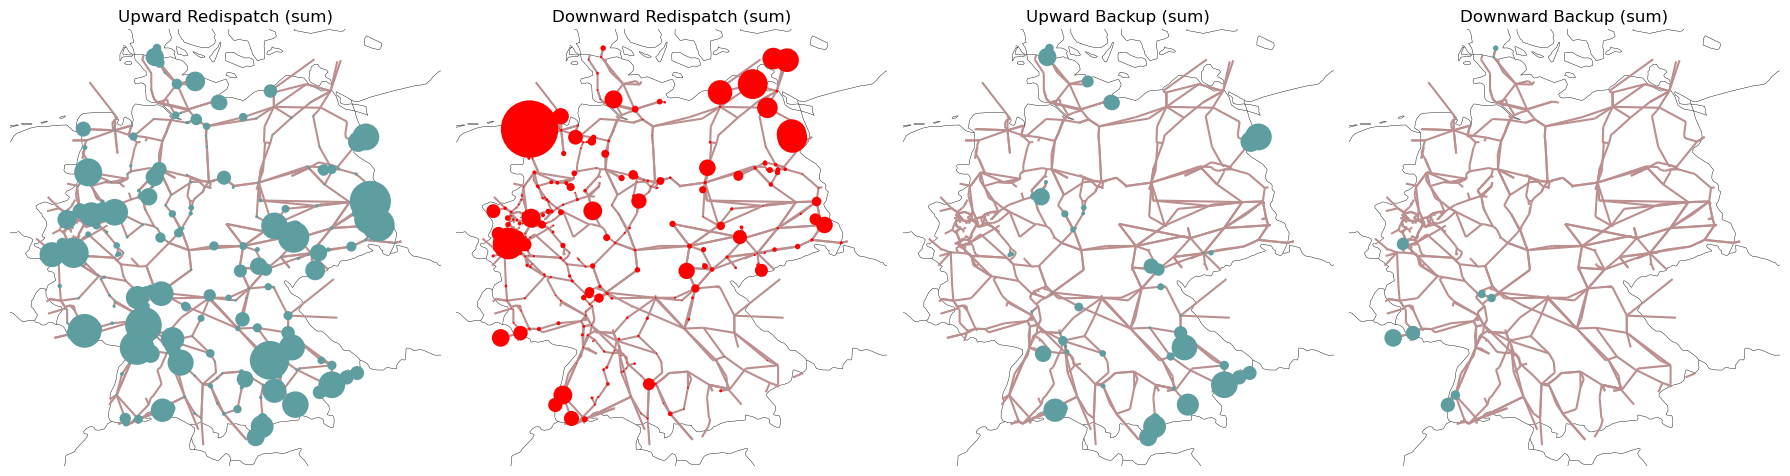

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

redisp_network = n.copy()

# ---- choose a time window ----
# Example: all snapshots
snap_sel = redisp_network.snapshots

# Or: a slice by position
# snap_sel = redisp_network.snapshots[0:24]

# Or: by datetime if snapshots are datetimes
# snap_sel = redisp_network.snapshots[(redisp_network.snapshots >= "2023-01-02") & (redisp_network.snapshots < "2023-01-03")]

def bus_redispatch_over_time(net, gen_mask, snaps, agg="sum"):
    gens = net.generators[gen_mask]
    if gens.empty:
        return None

    p = net.generators_t.p.loc[snaps, gens.index]

    if agg == "sum":
        p_agg = p.sum(axis=0)          # MWh if timestep=1h, else MW*hours
    elif agg == "mean":
        p_agg = p.mean(axis=0)         # average MW
    elif agg == "max":
        p_agg = p.max(axis=0)          # peak MW
    else:
        raise ValueError("agg must be one of: sum, mean, max")

    # group to buses
    return p_agg.groupby(gens.bus).sum()

fig, axs = plt.subplots(1, 4, figsize=(18, 8), subplot_kw={"projection": ccrs.EqualEarth()})

up_bus   = bus_redispatch_over_time(redisp_network, redisp_network.generators.index.str.endswith("_up"),          snap_sel, agg="sum")
down_bus = bus_redispatch_over_time(redisp_network, redisp_network.generators.index.str.endswith("_down"),        snap_sel, agg="sum")
bup_bus  = bus_redispatch_over_time(redisp_network, redisp_network.generators.index.str.endswith("_backup_up"),   snap_sel, agg="sum")
bdn_bus  = bus_redispatch_over_time(redisp_network, redisp_network.generators.index.str.endswith("_backup_down"), snap_sel, agg="sum")

scale = 1e-5

redisp_network.plot(bus_sizes=scale * up_bus,   ax=axs[0], title="Upward Redispatch (sum)",   geomap=True)
redisp_network.plot(bus_sizes=scale * down_bus, ax=axs[1], bus_colors="red", title="Downward Redispatch (sum)", geomap=True)
redisp_network.plot(bus_sizes=scale * bup_bus,  ax=axs[2], title="Upward Backup (sum)",      geomap=True)
redisp_network.plot(bus_sizes=scale * bdn_bus,  ax=axs[3], title="Downward Backup (sum)",    geomap=True)

plt.tight_layout()
plt.show()


Index(['demand_CRM_pos', 'demand_CRM_neg'], dtype='object', name='Load')
c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



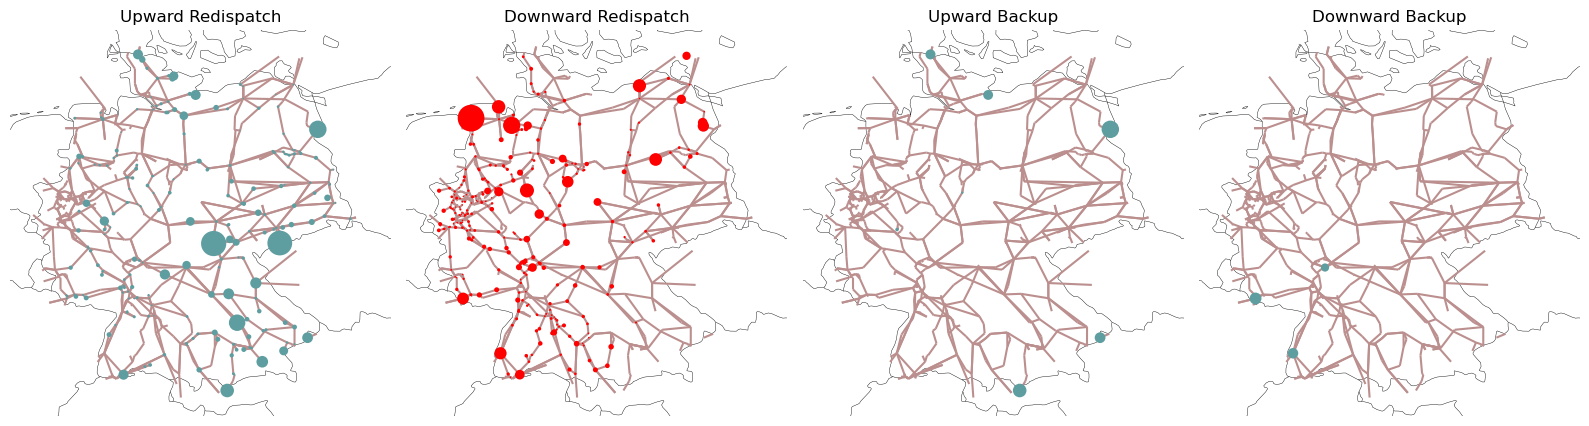

In [53]:
redisp_network = n.copy()
fig, axs = plt.subplots(1, 4, figsize=(16, 8), subplot_kw={"projection": ccrs.EqualEarth()})

# Plot the positive redispatch
pos_gen = redisp_network.generators[redisp_network.generators.index.str.endswith('_up')]
pos_gen_distr = (redisp_network.generators_t.p.loc[redisp_network.snapshots[1], pos_gen.index]
                 .groupby(pos_gen.bus).sum())
redisp_network.plot(bus_sizes=1e-4 * pos_gen_distr, ax=axs[0], title="Upward Redispatch", geomap=True)

# Plot the negative redispatch
neg_gen = redisp_network.generators[redisp_network.generators.index.str.endswith('_down')]
neg_gen_distr = (redisp_network.generators_t.p.loc[redisp_network.snapshots[1], neg_gen.index]
                 .groupby(neg_gen.bus).sum())
redisp_network.plot(bus_sizes=1e-4 * neg_gen_distr, ax=axs[1], bus_colors="red", title="Downward Redispatch", geomap=True)

# Plot the Negative backup redispatch
pos_gen = redisp_network.generators[redisp_network.generators.index.str.endswith('_backup_up')]
pos_gen_distr = (redisp_network.generators_t.p.loc[redisp_network.snapshots[1], pos_gen.index]
                 .groupby(pos_gen.bus).sum())
redisp_network.plot(bus_sizes=1e-4 * pos_gen_distr, ax=axs[2], title="Upward Backup", geomap=True)


# Plot the Negative backup redispatch
pos_gen = redisp_network.generators[redisp_network.generators.index.str.endswith('_backup_down')]
pos_gen_distr = (redisp_network.generators_t.p.loc[redisp_network.snapshots[1], pos_gen.index]
                 .groupby(pos_gen.bus).sum())
redisp_network.plot(bus_sizes=1e-4 * pos_gen_distr, ax=axs[3], title="Downward Backup", geomap=True)

plt.tight_layout()
plt.show()